In [3]:
from pyspark.sql import SparkSession
from pathlib import Path
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col

# Create SparkSession in local mode
spark = SparkSession.builder \
    .appName("FareTipModeling") \
    .master("local[*]") \
    .getOrCreate()


In [4]:
folder_path = Path(r"D:\L4S2\Big Data\assignment\NYC_Taxi_Trip_Data_Analysis\data\cleaned")

parquet_files = sorted(folder_path.glob("*.parquet"))
print(f"Found {len(parquet_files)} parquet files:")
for f in parquet_files:
    print(f.name)


Found 8 parquet files:
part-00000-c267671b-1832-48c2-97b7-10a9827a836f-c000.snappy.parquet
part-00001-c267671b-1832-48c2-97b7-10a9827a836f-c000.snappy.parquet
part-00002-c267671b-1832-48c2-97b7-10a9827a836f-c000.snappy.parquet
part-00003-c267671b-1832-48c2-97b7-10a9827a836f-c000.snappy.parquet
part-00004-c267671b-1832-48c2-97b7-10a9827a836f-c000.snappy.parquet
part-00005-c267671b-1832-48c2-97b7-10a9827a836f-c000.snappy.parquet
part-00006-c267671b-1832-48c2-97b7-10a9827a836f-c000.snappy.parquet
part-00007-c267671b-1832-48c2-97b7-10a9827a836f-c000.snappy.parquet


In [5]:
def filter_valid_fares_tips(df):
    filtered_df = df.filter((df.fare_amount > 0) & (df.tip_amount >= 0))
    print(f"Filtered from {df.count()} rows to {filtered_df.count()} rows with valid fare and tip amounts")
    return filtered_df


In [6]:
for file_path in parquet_files:
    print(f"\nProcessing file: {file_path.name}")
    df = spark.read.parquet(str(file_path))
    
    # Run your filter
    filtered_df = filter_valid_fares_tips(df)
    
    # You can add more processing steps here (e.g. modeling)



Processing file: part-00000-c267671b-1832-48c2-97b7-10a9827a836f-c000.snappy.parquet
Filtered from 3918134 rows to 3918134 rows with valid fare and tip amounts

Processing file: part-00001-c267671b-1832-48c2-97b7-10a9827a836f-c000.snappy.parquet
Filtered from 3933455 rows to 3933455 rows with valid fare and tip amounts

Processing file: part-00002-c267671b-1832-48c2-97b7-10a9827a836f-c000.snappy.parquet
Filtered from 3928190 rows to 3928190 rows with valid fare and tip amounts

Processing file: part-00003-c267671b-1832-48c2-97b7-10a9827a836f-c000.snappy.parquet
Filtered from 3936382 rows to 3936382 rows with valid fare and tip amounts

Processing file: part-00004-c267671b-1832-48c2-97b7-10a9827a836f-c000.snappy.parquet
Filtered from 3930808 rows to 3930808 rows with valid fare and tip amounts

Processing file: part-00005-c267671b-1832-48c2-97b7-10a9827a836f-c000.snappy.parquet
Filtered from 5205187 rows to 5205187 rows with valid fare and tip amounts

Processing file: part-00006-c2676

In [7]:
df = spark.read.parquet(str(parquet_files[0]))
print(df.columns)


['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'Airport_fee']


In [8]:
#calculate the total size of the data set
from pathlib import Path

folder_path = Path(r"D:\L4S2\Big Data\assignment\NYC_Taxi_Trip_Data_Analysis\data\cleaned")

total_size_bytes = sum(f.stat().st_size for f in folder_path.glob("*.parquet"))
total_size_mb = total_size_bytes / (1024 * 1024)

print(f"Total dataset size: {total_size_mb:.2f} MB")


📦 Total dataset size: 624.47 MB


In [9]:
# Load and combine all Parquet files into one DataFrame
df_all = spark.read.parquet(*[str(p) for p in parquet_files])

# Select 50 sample values from the tip_amount column
print("Sample 50 values from 'tip_amount' column:")
df_all.select("tip_amount").limit(50).show(50, truncate=False)


🎯 Sample 50 values from 'tip_amount' column:
+----------+
|tip_amount|
+----------+
|0.0       |
|1.0       |
|1.0       |
|0.0       |
|3.0       |
|3.42      |
|2.08      |
|2.72      |
|4.0       |
|2.0       |
|0.1       |
|3.84      |
|0.0       |
|6.64      |
|3.84      |
|2.44      |
|0.0       |
|2.13      |
|2.0       |
|2.44      |
|2.08      |
|3.28      |
|0.0       |
|4.68      |
|5.0       |
|2.0       |
|0.0       |
|4.26      |
|3.4       |
|4.26      |
|1.85      |
|0.0       |
|0.0       |
|16.15     |
|2.0       |
|2.1       |
|2.0       |
|4.3       |
|2.0       |
|0.0       |
|0.0       |
|5.8       |
|4.1       |
|1.0       |
|1.0       |
|3.4       |
|0.0       |
|3.15      |
|2.45      |
|7.6       |
+----------+



In [10]:
# Drop 'total_amount' if it exists to avoid data leakage
if 'total_amount' in filtered_df.columns:
    filtered_df = filtered_df.drop('total_amount')

# Select only numeric feature columns and drop target
feature_cols = [col for col in filtered_df.columns if col != 'tip_amount']
target_col = 'tip_amount'


Feature Engineering I


In [11]:
from pyspark.sql.functions import hour, dayofweek, unix_timestamp, col

# Add time-based features
engineered_df = filtered_df \
    .withColumn("pickup_hour", hour(col("tpep_pickup_datetime"))) \
    .withColumn("pickup_dayofweek", dayofweek(col("tpep_pickup_datetime"))) \
    .withColumn("trip_duration_minutes", 
                (unix_timestamp(col("tpep_dropoff_datetime")) - unix_timestamp(col("tpep_pickup_datetime"))) / 60)

# Optional: Drop original timestamp fields
engineered_df = engineered_df.drop("tpep_pickup_datetime", "tpep_dropoff_datetime")


In [12]:
from pyspark.sql.functions import when

engineered_df = engineered_df.withColumn("store_and_fwd_flag_numeric",
                                         when(col("store_and_fwd_flag") == "Y", 1).otherwise(0))

# Drop original string column
engineered_df = engineered_df.drop("store_and_fwd_flag")


In [13]:
from pyspark.sql.types import NumericType

numeric_cols = [f.name for f in engineered_df.schema.fields 
                if isinstance(f.dataType, NumericType) and f.name != "tip_amount"]

print("Final feature columns:")
print(numeric_cols)

assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features")
assembled_df = assembler.transform(engineered_df).select("features", "tip_amount")


Final feature columns:
['VendorID', 'passenger_count', 'trip_distance', 'RatecodeID', 'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tolls_amount', 'improvement_surcharge', 'congestion_surcharge', 'Airport_fee', 'pickup_hour', 'pickup_dayofweek', 'trip_duration_minutes', 'store_and_fwd_flag_numeric']


In [14]:
train_data, test_data = assembled_df.randomSplit([0.8, 0.2], seed=42)

lr = LinearRegression(featuresCol="features", labelCol="tip_amount")
lr_model = lr.fit(train_data)

predictions = lr_model.transform(test_data)

evaluator = RegressionEvaluator(
    labelCol="tip_amount", predictionCol="prediction", metricName="rmse"
)

rmse = evaluator.evaluate(predictions)
print(f"New RMSE with engineered features = {rmse:.2f}")


New RMSE with engineered features = 2.57


Feature Engineering II

In [16]:
from pyspark.sql.types import NumericType

# Get only numeric columns (exclude timestamps, strings, etc.)
numeric_cols = [f.name for f in filtered_df.schema.fields
                if isinstance(f.dataType, NumericType) and f.name != 'tip_amount']

print("Using these numeric columns for features:")
print(numeric_cols)

# Assemble features into 'features' column
assembler = VectorAssembler(inputCols=numeric_cols, outputCol='features')
assembled_df = assembler.transform(filtered_df).select('features', 'tip_amount')


Using these numeric columns for features:
['VendorID', 'passenger_count', 'trip_distance', 'RatecodeID', 'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tolls_amount', 'improvement_surcharge', 'congestion_surcharge', 'Airport_fee']


In [17]:
from pyspark.sql.functions import skewness

# Define numeric columns (already known)
numeric_cols = ['VendorID', 'passenger_count', 'trip_distance', 'RatecodeID', 'PULocationID', 
                'DOLocationID', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 
                'tolls_amount', 'improvement_surcharge', 'congestion_surcharge', 'Airport_fee']

# Exclude ID-like or categorical numeric columns
excluded_cols = ['VendorID', 'RatecodeID', 'PULocationID', 'DOLocationID', 'payment_type']
continuous_cols = [col for col in numeric_cols if col not in excluded_cols]

print("Computing skewness for continuous numeric columns:")
for col_name in continuous_cols:
    skew_val = filtered_df.select(skewness(col(col_name)).alias('skew')).collect()[0]['skew']
    print(f"{col_name}: {skew_val:.3f}")


Computing skewness for continuous numeric columns:
passenger_count: 2.471
trip_distance: 2.558
fare_amount: 2.224
extra: 1.499
mta_tax: -10.690
tolls_amount: 4.634
improvement_surcharge: -13.745
congestion_surcharge: -3.352
Airport_fee: 2.851


In [18]:
# Drop the specified columns
filtered_df = filtered_df.drop("mta_tax", "improvement_surcharge")

# Confirm by printing the schema
filtered_df.printSchema()


root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Airport_fee: double (nullable = true)



In [19]:
from pyspark.sql.functions import log1p

# Columns chosen based on high positive skewness
log_transform_cols = [
    "trip_distance", 
    "fare_amount", 
    "tolls_amount", 
    "Airport_fee", 
    "passenger_count"
]

# Apply log1p transformation to each of the selected columns
for col_name in log_transform_cols:
    filtered_df = filtered_df.withColumn(f"log_{col_name}", log1p(col(col_name)))

# Show a few rows to verify transformation
filtered_df.select([f"log_{col}" for col in log_transform_cols]).show(5)


+------------------+------------------+----------------+---------------+-------------------+
| log_trip_distance|   log_fare_amount|log_tolls_amount|log_Airport_fee|log_passenger_count|
+------------------+------------------+----------------+---------------+-------------------+
|0.8754687373538999|  2.33214389523559|             0.0|            0.0| 1.0986122886681096|
|0.9555114450274365| 2.624668592163159|             0.0|            0.0| 0.6931471805599453|
|0.9162907318741551|2.2617630984737906|             0.0|            0.0| 0.6931471805599453|
|0.5877866649021191| 1.916922612182061|             0.0|            0.0| 0.6931471805599453|
|1.8625285401162623| 3.349904087274605|             0.0|            0.0| 0.6931471805599453|
+------------------+------------------+----------------+---------------+-------------------+
only showing top 5 rows


In [20]:
from pyspark.sql.functions import skewness

# List of log-transformed columns
log_cols = [
    "log_trip_distance",
    "log_fare_amount",
    "log_tolls_amount",
    "log_Airport_fee",
    "log_passenger_count"
]

# Compute skewness for each
print("Skewness after logarithmic transformation:")
for col in log_cols:
    skew_val = filtered_df.select(skewness(col)).first()[0]
    print(f"{col}: {skew_val:.3f}")


Skewness after logarithmic transformation:
log_trip_distance: 1.132
log_fare_amount: 0.699
log_tolls_amount: 3.095
log_Airport_fee: 2.851
log_passenger_count: 1.993


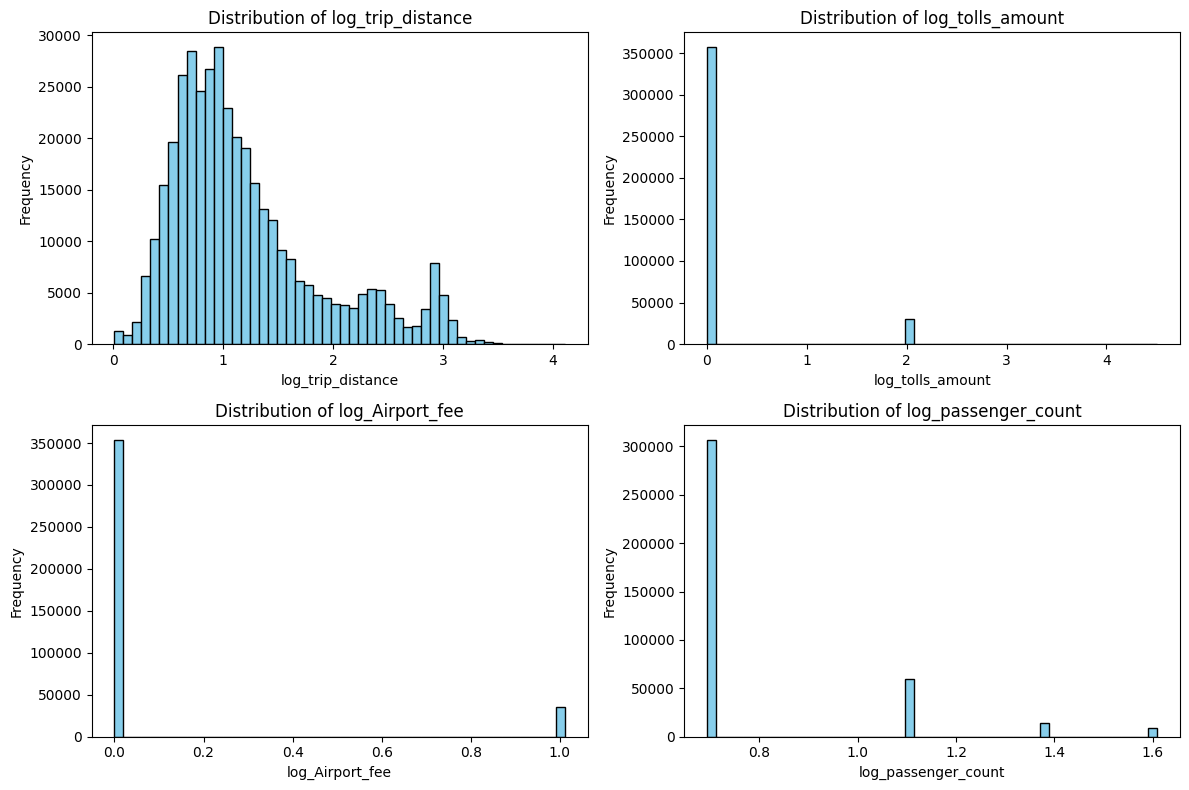

In [21]:
import matplotlib.pyplot as plt

# Convert filtered_df to Pandas (sample for plotting if dataset is large)
sample_df = filtered_df.select(
    "log_trip_distance", 
    "log_tolls_amount", 
    "log_Airport_fee", 
    "log_passenger_count"
).sample(fraction=0.1, seed=42).toPandas()

# Set up plots
plt.figure(figsize=(12, 8))
cols_to_plot = sample_df.columns
for i, col in enumerate(cols_to_plot, 1):
    plt.subplot(2, 2, i)
    plt.hist(sample_df[col], bins=50, color='skyblue', edgecolor='black')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [22]:
from pyspark.sql.functions import sqrt, col
from pyspark.sql.functions import skewness

# Apply square root transformation on 'log_trip_distance'
filtered_df = filtered_df.withColumn('sqrt_log_trip_distance', sqrt(col('log_trip_distance')))

# Calculate skewness of the transformed column
skew_val = filtered_df.select(skewness('sqrt_log_trip_distance')).first()[0]
print(f"Skewness of sqrt_log_trip_distance: {skew_val:.3f}")


Skewness of sqrt_log_trip_distance: 0.526


In [23]:
from pyspark.sql.functions import col

transformed_cols = [
    'sqrt_log_trip_distance',
    'log_fare_amount',
    'log_tolls_amount',
    'log_Airport_fee',
    'log_passenger_count'
]

def detect_outliers(df, col_name):
    quantiles = df.approxQuantile(col_name, [0.25, 0.75], 0.0)
    Q1, Q3 = quantiles[0], quantiles[1]
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers_df = df.filter((col(col_name) < lower_bound) | (col(col_name) > upper_bound))

    print(f"Column: {col_name}")
    print(f"  Q1={Q1:.3f}, Q3={Q3:.3f}, IQR={IQR:.3f}")
    print(f"  Lower Bound={lower_bound:.3f}, Upper Bound={upper_bound:.3f}")
    print(f"  Outliers count: {outliers_df.count()}")
    print(f"  Sample outliers:")
    outliers_df.select(col_name).show(5, truncate=False)

for c in transformed_cols:
    detect_outliers(filtered_df, c)


Column: sqrt_log_trip_distance
  Q1=0.841, Q3=1.213, IQR=0.372
  Lower Bound=0.283, Upper Bound=1.771
  Outliers count: 26400
  Sample outliers:
+----------------------+
|sqrt_log_trip_distance|
+----------------------+
|1.8163602770642733    |
|0.26011276107452863   |
|1.8125706465317275    |
|0.26011276107452863   |
|0.1407218081754911    |
+----------------------+
only showing top 5 rows
Column: log_fare_amount
  Q1=2.332, Q3=3.131, IQR=0.799
  Lower Bound=1.134, Upper Bound=4.330
  Outliers count: 36323
  Sample outliers:
+-----------------+
|log_fare_amount  |
+-----------------+
|4.457829598089382|
|4.457829598089382|
|4.550714000192032|
|4.394449154672439|
|4.486949554600661|
+-----------------+
only showing top 5 rows
Column: log_tolls_amount
  Q1=0.000, Q3=0.000, IQR=0.000
  Lower Bound=0.000, Upper Bound=0.000
  Outliers count: 321450
  Sample outliers:
+------------------+
|log_tolls_amount  |
+------------------+
|2.0719132752590443|
|2.0719132752590443|
|2.0719132752590443

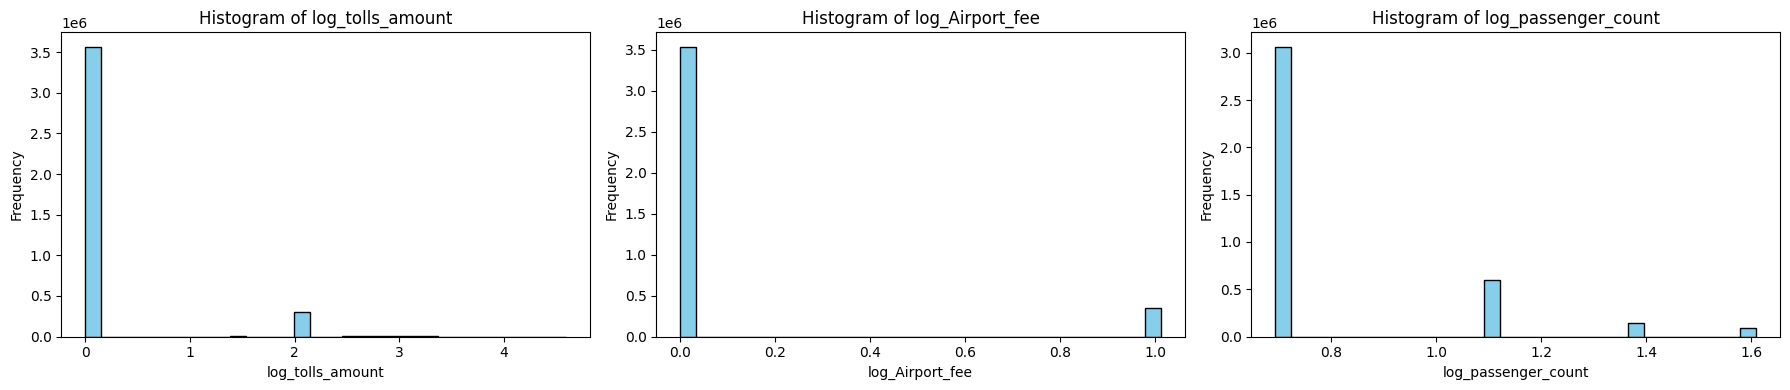

In [24]:
import matplotlib.pyplot as plt
import pandas as pd

# Select the columns and convert to Pandas DataFrame
cols_to_plot = ['log_tolls_amount', 'log_Airport_fee', 'log_passenger_count']
pdf = filtered_df.select(cols_to_plot).toPandas()

# Plot histograms
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

for i, col in enumerate(cols_to_plot):
    axes[i].hist(pdf[col], bins=30, color='skyblue', edgecolor='black')
    axes[i].set_title(f'Histogram of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


In [25]:
from pyspark.ml.feature import VectorAssembler, StandardScaler

# 1. Assemble the transformed columns into a single feature vector
assembler = VectorAssembler(inputCols=transformed_cols, outputCol="features")
assembled_df = assembler.transform(filtered_df)

# 2. Apply StandardScaler
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)
scaler_model = scaler.fit(assembled_df)
scaled_df = scaler_model.transform(assembled_df)

# 3. Preview the scaled feature vector
scaled_df.select("scaled_features").show(truncate=False)


+--------------------------------------------------------------------------------------------------------+
|scaled_features                                                                                         |
+--------------------------------------------------------------------------------------------------------+
|[-0.39244666212714385,-0.7108490797374938,-0.298784734160729,-0.31578742063016385,1.3336293861237207]   |
|[-0.25225875572376366,-0.25818762373637144,-0.298784734160729,-0.31578742063016385,-0.4830441105708463] |
|[-0.32018476978772603,-0.8197584274655031,-0.298784734160729,-0.31578742063016385,-0.4830441105708463]  |
|[-0.9586976266957425,-1.3533748990060228,-0.298784734160729,-0.31578742063016385,-0.4830441105708463]   |
|[1.0452923219156587,0.8640634497930797,-0.298784734160729,-0.31578742063016385,-0.4830441105708463]     |
|[1.5645880062935031,1.4040014995120151,3.256979144770814,3.166700581391069,-0.4830441105708463]         |
|[-0.5185180571540438,-0.936917162517

In [26]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=transformed_cols,
    outputCol="features"
)

assembled_df = assembler.transform(filtered_df)


In [27]:
train_data, test_data = assembled_df.randomSplit([0.8, 0.2], seed=42)


In [28]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol='features', labelCol='tip_amount')
lr_model = lr.fit(train_data)


In [29]:
predictions = lr_model.transform(test_data)

from pyspark.ml.evaluation import RegressionEvaluator

rmse = RegressionEvaluator(labelCol='tip_amount', predictionCol='prediction', metricName='rmse').evaluate(predictions)
r2 = RegressionEvaluator(labelCol='tip_amount', predictionCol='prediction', metricName='r2').evaluate(predictions)

print(f"RMSE: {rmse:.3f}")
print(f"R-squared: {r2:.3f}")


RMSE: 3.073
R-squared: 0.407


In [30]:
train_data, test_data = assembled_df.randomSplit([0.8, 0.2], seed=42)
print(f"Training rows: {train_data.count()}, Testing rows: {test_data.count()}")


Training rows: 3108808, Testing rows: 777808


In [31]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol='features', labelCol='tip_amount')
lr_model = lr.fit(train_data)


In [32]:
predictions = lr_model.transform(test_data)
predictions.select("features", "tip_amount", "prediction").show(5)


+--------------------+----------+------------------+
|            features|tip_amount|        prediction|
+--------------------+----------+------------------+
|[1.57101862862017...|     12.95|10.566287682068062|
|[0.42699128421310...|       0.0|1.9586082235021811|
|[1.26863624117951...|       1.0| 4.460385927759457|
|[0.76667246259541...|       0.0| 2.695888407774543|
|[0.95723076208099...|      3.65|  2.41909833542703|
+--------------------+----------+------------------+
only showing top 5 rows


In [33]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(
    labelCol='tip_amount', predictionCol='prediction', metricName='rmse')

rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) on test data = {rmse:.2f}")


Root Mean Squared Error (RMSE) on test data = 3.07


Random Forest

In [34]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# 1. Initialize the Random Forest Regressor
rf = RandomForestRegressor(featuresCol="features", labelCol="tip_amount", seed=42)

# 2. Train the model on training data
rf_model = rf.fit(train_data)

# 3. Predict on test data
predictions = rf_model.transform(test_data)

# 4. Evaluate the model performance
evaluator_rmse = RegressionEvaluator(labelCol="tip_amount", predictionCol="prediction", metricName="rmse")
rmse = evaluator_rmse.evaluate(predictions)

evaluator_r2 = RegressionEvaluator(labelCol="tip_amount", predictionCol="prediction", metricName="r2")
r2 = evaluator_r2.evaluate(predictions)

print(f"Random Forest RMSE: {rmse}")
print(f"Random Forest R2: {r2}")


Random Forest RMSE: 3.016047209319717
Random Forest R2: 0.42932108060777463


Gradient Boost

In [35]:
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Step 1: Create the GBT model
gbt = GBTRegressor(featuresCol='features', labelCol='tip_amount', maxIter=100)

# Step 2: Fit the model to your training data
gbt_model = gbt.fit(train_data)

# Step 3: Make predictions on the test data
gbt_predictions = gbt_model.transform(test_data)

# Step 4: Evaluate the model
evaluator = RegressionEvaluator(
    labelCol="tip_amount",
    predictionCol="prediction",
    metricName="rmse"
)
rmse = evaluator.evaluate(gbt_predictions)

r2_evaluator = RegressionEvaluator(
    labelCol="tip_amount",
    predictionCol="prediction",
    metricName="r2"
)
r2 = r2_evaluator.evaluate(gbt_predictions)

print(f"GBT RMSE: {rmse}")
print(f"GBT R2: {r2}")


GBT RMSE: 2.980296606034281
GBT R2: 0.44276994024685024


Hyperparameter tuning for Gradient Boosted Tree

In [36]:
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit

# Define the GBT Regressor
gbt = GBTRegressor(featuresCol='features', labelCol='tip_amount')

# Define the parameter grid (smaller for faster tuning)
param_grid = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [3, 5]) \
    .addGrid(gbt.maxIter, [20, 50]) \
    .addGrid(gbt.stepSize, [0.1]) \
    .build()

# Define evaluator for RMSE
evaluator_rmse = RegressionEvaluator(
    labelCol='tip_amount', 
    predictionCol='prediction', 
    metricName='rmse'
)

# Define TrainValidationSplit (faster than CrossValidator)
tvs = TrainValidationSplit(
    estimator=gbt,
    estimatorParamMaps=param_grid,
    evaluator=evaluator_rmse,
    trainRatio=0.8  # 80% training, 20% validation
)

# (Optional) Time the training process
import time
start_time = time.time()

# Fit the model on training data
tvs_model = tvs.fit(train_data)

end_time = time.time()
print(f"Training completed in {(end_time - start_time)/60:.2f} minutes")

# Make predictions on test data
predictions = tvs_model.transform(test_data)

# Evaluate RMSE and R-squared on test set
rmse = evaluator_rmse.evaluate(predictions)
r2 = RegressionEvaluator(
    labelCol='tip_amount', 
    predictionCol='prediction', 
    metricName='r2'
).evaluate(predictions)

print(f"Tuned GBT RMSE: {rmse:.3f}")
print(f"Tuned GBT R2: {r2:.3f}")


Training completed in 28.79 minutes
Tuned GBT RMSE: 2.982
Tuned GBT R2: 0.442


Add new feature engineering methods

In [37]:
from pyspark.sql.functions import hour, dayofweek, month, unix_timestamp, when

# Convert datetime strings to timestamp (if not already)
df = df.withColumn("pickup_datetime", df["tpep_pickup_datetime"].cast("timestamp"))
df = df.withColumn("dropoff_datetime", df["tpep_dropoff_datetime"].cast("timestamp"))

# Trip duration in minutes
df = df.withColumn("trip_duration_minutes", 
                   (unix_timestamp("dropoff_datetime") - unix_timestamp("pickup_datetime")) / 60)

# Extract hour, day, month
df = df.withColumn("pickup_hour", hour("pickup_datetime"))
df = df.withColumn("pickup_dayofweek", dayofweek("pickup_datetime"))  # Sunday = 1
df = df.withColumn("pickup_month", month("pickup_datetime"))

# Weekend & Night flags
df = df.withColumn("is_weekend", when((df["pickup_dayofweek"] >= 6), 1).otherwise(0))
df = df.withColumn("is_night", when((df["pickup_hour"] < 6) | (df["pickup_hour"] >= 22), 1).otherwise(0))


In [38]:
from pyspark.sql.functions import col, when

# Avoid division by zero
df = df.withColumn("tip_per_mile", when(col("trip_distance") != 0, col("tip_amount") / col("trip_distance")).otherwise(0))
df = df.withColumn("tip_percent_fare", when(col("fare_amount") != 0, col("tip_amount") / col("fare_amount")).otherwise(0))
df = df.withColumn("fare_per_minute", when(col("trip_duration_minutes") != 0, col("fare_amount") / col("trip_duration_minutes")).otherwise(0))


In [39]:
# Sample: tag common airport zones
airport_ids = [1, 132, 138, 140]  # Example IDs for JFK, LGA, EWR

df = df.withColumn("is_airport_trip", when(col("PULocationID").isin(airport_ids) | col("DOLocationID").isin(airport_ids), 1).otherwise(0))
df = df.withColumn("is_same_zone", when(col("PULocationID") == col("DOLocationID"), 1).otherwise(0))


In [40]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

# Categorical columns
categorical_cols = ["VendorID", "RatecodeID", "store_and_fwd_flag", "payment_type"]
indexers = [StringIndexer(inputCol=col, outputCol=col + "_idx") for col in categorical_cols]
encoders = [OneHotEncoder(inputCol=col + "_idx", outputCol=col + "_vec") for col in categorical_cols]

# Pipeline
pipeline = Pipeline(stages=indexers + encoders)
df = pipeline.fit(df).transform(df)


In [41]:
# Remove unrealistic values
df = df.filter((col("trip_distance") > 0) & (col("trip_distance") < 100))
df = df.filter((col("fare_amount") > 0) & (col("fare_amount") < 200))
df = df.filter((col("tip_amount") >= 0) & (col("tip_amount") < 100))


In [42]:
from pyspark.ml.feature import VectorAssembler, StandardScaler

numerical_features = ["trip_distance", "fare_amount", "trip_duration_minutes"]
assembler = VectorAssembler(inputCols=numerical_features, outputCol="num_features")
scaler = StandardScaler(inputCol="num_features", outputCol="scaled_features")

pipeline = Pipeline(stages=[assembler, scaler])
df = pipeline.fit(df).transform(df)


In [43]:
from pyspark.sql.functions import expr

df = df.withColumn("fare_x_distance", col("fare_amount") * col("trip_distance"))
df = df.withColumn("duration_x_distance", col("trip_duration_minutes") * col("trip_distance"))


In [44]:
from pyspark.sql.functions import monotonically_increasing_id, col
from pyspark.ml.evaluation import RegressionEvaluator

# Step 1: Order and add row_id to test_data
ordered_test_data = test_data.orderBy("VendorID")  # Use a stable column
test_data_with_id = ordered_test_data.withColumn("row_id", monotonically_increasing_id())

# Step 2: Generate predictions from both models with row_id

# Random Forest
rf_preds = rf_model.transform(test_data_with_id)\
    .select("row_id", "prediction")\
    .withColumnRenamed("prediction", "rf_pred")

# GBT
gbt_preds = gbt_model.transform(test_data_with_id)\
    .select("row_id", "prediction")\
    .withColumnRenamed("prediction", "gbt_pred")

# Step 3: Join predictions using row_id
blended_preds = rf_preds.join(gbt_preds, on="row_id")

# Step 4: Average predictions
blended_preds = blended_preds.withColumn(
    "final_prediction", (col("rf_pred") + col("gbt_pred")) / 2
)

# Step 5: Attach the true label (tip_amount) to evaluate
true_labels = test_data_with_id.select("row_id", "tip_amount")
final_df = blended_preds.join(true_labels, on="row_id")


# Step 6: Evaluate blended model
evaluator_rmse = RegressionEvaluator(labelCol="tip_amount", predictionCol="final_prediction", metricName="rmse")
evaluator_r2 = RegressionEvaluator(labelCol="tip_amount", predictionCol="final_prediction", metricName="r2")

rmse = evaluator_rmse.evaluate(final_df)
r2 = evaluator_r2.evaluate(final_df)

print(f"Blended Model RMSE: {rmse:.3f}")
print(f"Blended Model R2: {r2:.3f}")


Blended Model RMSE: 2.988
Blended Model R2: 0.440
